# Tutorial

From recipe to gridded netcdf product, a how-to!

In [1]:
# Import the functions we are going to use, FYI one day this should be
# a simple import stitches call

import stitches.pangeo_fx as pangeo
import stitches.netcdf_fx as nc
import pandas as pd
import stitches.gridstitch_fx as stitch
import stitches.calculatetgav as mm
import xarray as xr
from matplotlib import pyplot as plt


/Users/dorh012/Documents/2021/py-stitches/stitches/stitches/pkgimports.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Load recipe

In [2]:
# Load a recipe, this is a csv file that is generated in the R portion of the
# the project. Note that the recipe must contain information about the
# target and archive years, stitching_id.
# The recipes returned from the R code will only have the tas file info in a column
# called file. This is because the R code is semi-agnostic to what variables will
# get called for gridded stitching; the R code only operates on Tgav. We happen to
# have generated these example recipes on an archive of data for which tas, pr, and
# psl files are all available on pangeo.

#local_path = '/Users/snyd535/Documents/task11a-topdown-clim-ML/stitches'
 local_path = '/Users/dorh012/projects/2021/py-stitches/stitches'
recipe = pd.read_csv(local_path + '/notebooks/stitches_dev/generated_ensembles/MPI-ESM1-2-LR_gridded_recipes_for_python_ssp245_draw100_experiment_in_matching.csv')
print(recipe.head(3))



        stitching_id  target_start_yr  target_end_yr  archive_start_yr  \
0  ssp245~r2i1p1f1~1             1850           1858              1859   
1  ssp245~r2i1p1f1~1             1859           1867              1913   
2  ssp245~r2i1p1f1~1             1868           1876              1931   

   archive_end_yr                                               file  
0            1867  gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...  
1            1921  gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...  
2            1939  gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...  


In [3]:
# For stitching gridded data, the recipe needs to be updated with
# pangeo z-file information for all variables of interest.
# They must be contained in columns titled
# with `var_file` eg tas_file, pr_file, etc. This can be for an
# arbitrary number variables, so long as it matches that column
# naming pattern.

# Load in the metadata:
metadata = pd.read_csv(local_path + '/notebooks/stitches_dev/inputs/pangeo_path_metadata_tas_psl_pr_tmax_tmin.csv')
metadata = metadata.rename(columns={"tas_zstore":"tas_file",
                                    "pr_zstore":"pr_file",
                                    "psl_zstore":"psl_file"}).copy()
print(metadata.head(3))

# Rename the recipe's `file` column  to `tas_file`
# TODO for ACS: add to R code so that these come out of the stitched recipes
recipe = recipe.rename(columns={"file":"tas_file"}).copy()


  activity_id institution_id    source_id experiment_id member_id table_id  \
0        CMIP      NASA-GISS  GISS-E2-1-G    historical  r2i1p1f1     Amon   
1        CMIP      NASA-GISS  GISS-E2-1-G    historical  r1i1p1f1     Amon   
2        CMIP      NASA-GISS  GISS-E2-1-G    historical  r3i1p1f1     Amon   

  grid_label                                           tas_file  \
0         gn  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...   
1         gn  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...   
2         gn  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...   

   dcpp_init_year   version psl_file pr_file tasmax_zstore tasmin_zstore  
0             NaN  20180827      NaN     NaN           NaN           NaN  
1             NaN  20180827      NaN     NaN           NaN           NaN  
2             NaN  20180828      NaN     NaN           NaN           NaN  


In [4]:
# do a left_join(recipe, select(metadata, tas_file, pr_file, psl_file)
recipe = pd.merge(left = recipe,
                  right = metadata[["tas_file", "pr_file", "psl_file",
                                    "activity_id", "institution_id", "source_id",
                                    "experiment_id", "member_id"]],
                  how = "left").copy()
# now we have gone from R-produced recipe through to the kind of multi-var recipe
# this tutorial expects
recipe.head(3)


,stitching_id,target_start_yr,target_end_yr,archive_start_yr,archive_end_yr,tas_file,pr_file,psl_file,activity_id,institution_id,source_id,experiment_id,member_id
0,ssp245~r2i1p1f1~1,1850,1858,1859,1867,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r2i1p1f1
1,ssp245~r2i1p1f1~1,1859,1867,1913,1921,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1
2,ssp245~r2i1p1f1~1,1868,1876,1931,1939,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r6i1p1f1


My guess is that the next steps will probably be wrapped into an easy to use
function but for now let's walk through the steps individually.


## Download data

In [5]:
# Save a copy of the unique file list to minimize the number of files we have to
# download from pangeo. Because we are working with an arbitrary number of variables
# use a helper function.
file_list = pangeo.find_zfiles(recipe)

In [6]:
# Now pull the netcdf files directly from pangeo! Here we are
# pulling all of the netcdf files we will need in the stitcing
# process at once to limit the number of times we have to do this.
# the length of time this call takes to run depends on the number of
# files we need to import.
data_list = pangeo.get_data_from_pangeo(file_list)


## Stitch data into product

In [7]:
# Select a single one of the stitching ids to stitch together.
id = recipe['stitching_id'].unique()[0]
x = recipe[recipe['stitching_id'] == id].copy()

# Parse out the variable name so that we can use it
# to label the final output.
file_column_names = x.filter(regex='file').columns.tolist()
vars = nc.get_var_names(file_column_names)

In [8]:
# Create the xarray of the stitched data, we will probably
# want to optimize this.
out = stitch.stitch_gridded(rp=x,
                            dl=data_list,
                            fl=file_list)

In [9]:
# Open the netcdf files.
out_tas = xr.open_dataset(out[0])
out_pr = xr.open_dataset(out[1])
out_psl = xr.open_dataset(out[2])



## Let's take a look at what we made!

In [10]:
out_tas.attrs["variable"]

'tas'

In [11]:
# here  is a copy of the recpie that I have stored in the meta data!
out_tas.attrs["recipe"]


'         stitching_id  target_start_yr  target_end_yr  archive_start_yr  archive_end_yr                                                                                  tas_file                                                                                  pr_file                                                                                  psl_file  activity_id institution_id      source_id experiment_id  member_id\n0   ssp245~r2i1p1f1~1             1850           1858              1859            1867      gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r2i1p1f1/Amon/tas/gn/v20190710/      gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r2i1p1f1/Amon/pr/gn/v20190710/      gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r2i1p1f1/Amon/psl/gn/v20190710/         CMIP          MPI-M  MPI-ESM1-2-LR    historical   r2i1p1f1\n1   ssp245~r2i1p1f1~1             1859           1867              1913            1921      gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r

### maps!

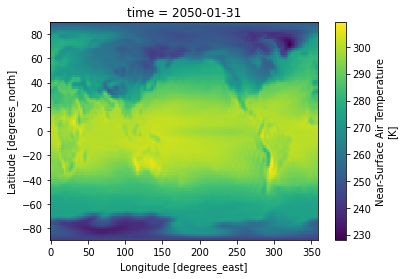

In [12]:
# tas plot!
out_tas.tas.sel(time='2050-01').squeeze().plot()

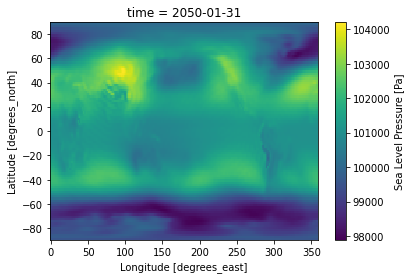

In [13]:
# psl plot!
out_psl.psl.sel(time='2050-01').squeeze().plot()

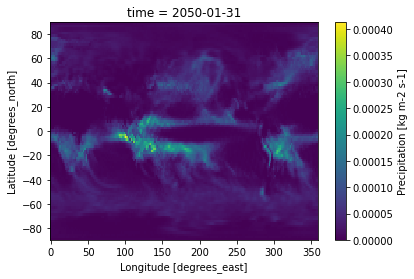

In [14]:
# pr plot!
out_pr.pr.sel(time='2050-01').squeeze().plot()


### global means?

In [15]:
# calculate weighted means
rslt_tas = mm.global_mean(out_tas)
rslt_psl = mm.global_mean(out_psl)
rslt_pr = mm.global_mean(out_pr)


Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

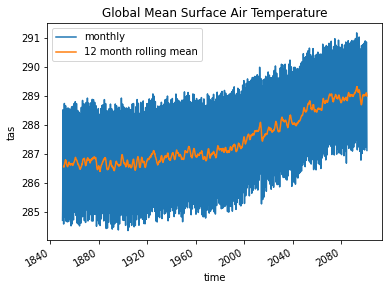

In [16]:
rslt_tas.tas.plot(label='monthly')
rslt_tas.tas.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')

Text(0.5, 1.0, 'Sea Level Pressure')

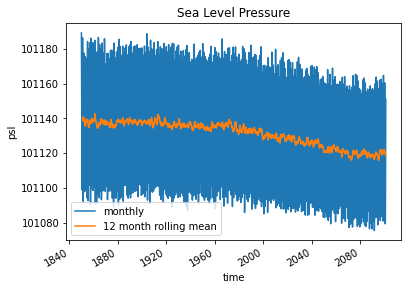

In [17]:
rslt_psl.psl.plot(label='monthly')
rslt_psl.psl.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title(out_psl.psl.attrs['long_name'])

Text(0.5, 1.0, 'Precipitation')

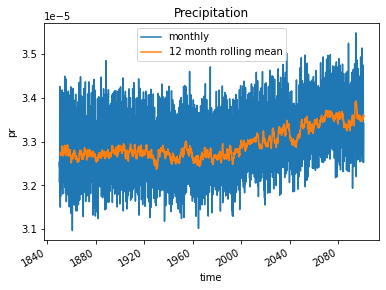

In [18]:
rslt_pr.pr.plot(label='monthly')
rslt_pr.pr.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title(out_pr.pr.attrs['long_name'])

## How to loop over multiple recipes!

Note my guess is that one day this will be wrapped into a function.


In [ ]:
# uncomment code to run 
# Loop through the other recipes
#    for id in recipe['stitching_id'].unique():
#        # subset for a single recipie
#        x = recipe[recipe['stitching_id'] == id].copy()
#
#        # Parse out the variable name so that we can use it
#        # to label the final output.
#        file_column_names = x.filter(regex='file').columns.tolist()
#        vars = get_var_names(file_column_names)
#
#        # Create the xarray of the stitched data, may want to figure if
#        # there is some way to optmize this cause it is a tad slow...
#        out = stitch_gridded(rp=x, dl=data_list, fl=file_list)